We employ our selected model to quantify the marginal effect that exceedance (EXC) has on 2100 GDP. 

In [74]:
from pathlib import Path
import os
import sys

sys.path.append(Path(os.path.abspath('')).parent.parent)
os.chdir(Path(os.path.abspath('')).parent.parent)

import numpy as np
import pandas as pd 
import xarray as xr
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold 
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import r2_score

import config.settings as cset

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

import geopandas as gpd 
from matplotlib import colormaps as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely import box

from config.settings import (labelsize_small, 
                            labelsize_medium, 
                            labelsize_large,
                            focus_countries,
                            focus_countries_names,
                            focus_countries_colors, 
                            focus_scenarios_color_dict
                            )


### Settings

In [75]:
thrshld = 1.35
thrshld_str = '135'

In [76]:
def compute_exc(gmt):
    gmt_tmp       = (gmt-thrshld).copy()
    gmt_tmp[gmt_tmp < 0] = 0
    gmt_exc       = gmt_tmp.sum()/(86)
    return(gmt_exc)

### Step 1: Load Data 

a. regression data from previous script
- we found that adding the StandardScaler does not alter regression results in our model framework (coefficients are robust to the scaling of predictive variables)
- therefore, to keep results easily interpretable, we omit the scaling here and work with the raw data

In [77]:
regression_df = pd.read_csv(cset.path_CHAR_results / f'regression_data_thsld_{thrshld_str}.csv', index_col = 0)
y = np.log(regression_df['diff_SSP2'])

# Define predictor variable space 
predictors = ['tas_soc', 'tas_baseline', 'gmt_eoc', 'gmt_exc']

# Generate second-order terms
poly       = PolynomialFeatures(2, interaction_only=False, include_bias=False)
X_poly     = poly.fit_transform(regression_df[predictors])

# Create a predictor matrix
poly_feature_names  = poly.get_feature_names_out(predictors)
predictor_df        = pd.DataFrame(X_poly, columns = poly_feature_names)
regression_df.index = predictor_df.index

# interactions with tas_baseline 
interaction_terms   = [f for f in poly_feature_names if (('tas_baseline' in f) & (f != 'tas_baseline') & (f != 'tas_baseline^2'))]
# Combine original predictors, interaction terms, and polynomial features 
all_predictors     = list(predictors) + list(interaction_terms) + list([f+'^2' for f in predictors])

# intercept matrix for country fixed effects  
n_countries = int(len(regression_df)/1000)
X_intercept = np.zeros((len(regression_df), n_countries))
for i in range(n_countries):
    X_intercept[i*1000:(i+1)*1000, i] = 1

In [78]:
gmt_ds = pd.read_csv(cset.path_MESMER_char / f'gmt_dataset.csv', index_col = 0)

### Step 3: Evaluating EXC effects in our Model 

a. Fitting Model 

In [79]:
# selected predictors 
base_predictors = ['tas_soc', 'tas_soc tas_baseline', 'gmt_eoc', 'tas_baseline gmt_eoc']
sel_predictors = base_predictors + ['gmt_exc', 'tas_baseline gmt_exc']

# predicotr matrix 
X = np.c_[predictor_df.loc[:, sel_predictors].values, X_intercept]

# fitted model 
linreg = sm.OLS(y, X).fit()

b. Evaluating marginal effects of EXC at 1.5°C of EOC warming

In [80]:
focus_temperatures = [regression_df[regression_df.iso == country].loc[:, 'tas_baseline'].mean() for country in focus_countries] 
EXCs = np.linspace(0, 1.1, 100)
eoc = 1.5

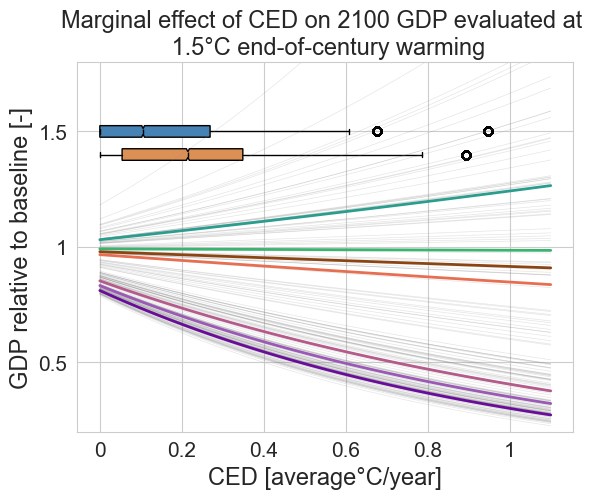

In [81]:
with sns.axes_style('whitegrid'):
    plt.figure()
    bar1 = plt.boxplot([regression_df[regression_df.scen_run.str.contains('Ref')].loc[:, 'gmt_exc'].values], 
                positions = [1.5], 
                widths = 0.05, 
                patch_artist = True, 
                boxprops=dict(facecolor = focus_scenarios_color_dict['Ref'], color='black'), 
                vert=False, 
                notch = True)
    bar2 = plt.boxplot([regression_df[regression_df.scen_run.str.contains('Neg')].loc[:, 'gmt_exc'].values], 
                positions = [1.4], 
                widths = 0.05, 
                patch_artist = True, 
                boxprops=dict(facecolor=focus_scenarios_color_dict['Neg'], color='black'), 
                vert=False, 
                notch = True)
    for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
            plt.setp(bar1[element], color='black')
            plt.setp(bar2[element], color='black')
    for t in np.sort(regression_df.loc[:, 'tas_baseline'].unique())[:]: 
        pred_exc_tmp =  np.array([[0, 0] + [eoc, eoc*t] + [exc, exc*t]+ [0]*157 for exc in EXCs])
        impact_tmp   = linreg.predict(pred_exc_tmp)
        plt.plot(EXCs, np.exp(impact_tmp), color = 'grey', alpha = .2, lw = 0.5)
    for i, country in enumerate(focus_countries_names):
        t = focus_temperatures[i]
        pred_exc_tmp =  np.array([[0,0] + [eoc, eoc*t] + [exc, exc*t]+ [0]*157 for exc in EXCs])
        impact_tmp   = linreg.predict(pred_exc_tmp)
        plt.plot(EXCs, np.exp(impact_tmp), label = focus_countries_names[i], lw = 2, color = focus_countries_colors[i])

    plt.xticks([0,0.2,0.4,0.6,0.8,1],
               ['0','0.2','0.4','0.6','0.8','1'],
               fontsize = labelsize_small)
    plt.yticks([0.5,1,1.5], 
               ['0.5','1','1.5'],
               fontsize = labelsize_small)
    plt.ylim(0.2,1.8)
    plt.xlabel('CED [average°C/year]',
               fontsize = labelsize_large)
    plt.ylabel('GDP relative to baseline [-]',
               fontsize = labelsize_large)
    plt.title('Marginal effect of CED on 2100 GDP evaluated at \n 1.5°C end-of-century warming', fontsize = labelsize_large)
    plt.show()

- Storing for final results plot

In [82]:
isos = regression_df.iso.unique()
baseline_temperatures = [regression_df[regression_df.iso == iso].loc[:, 'tas_baseline'].mean() for iso in isos]
impact_matrix = np.array([linreg.predict(np.array([[0, 0] + [eoc, eoc*t] + [exc, exc*t]+ [0]*157 for exc in EXCs])) for t in baseline_temperatures])
marginal_effects_all = pd.DataFrame(impact_matrix.T, 
                                    index = EXCs, 
                                    columns =  isos)
marginal_effects_all.to_csv(cset.path_CHAR_results / f'marginal_effects_EXC_all_countries_thsld_{thrshld_str}.csv')

impact_matrix = np.array([linreg.predict(np.array([[0, 0] + [eoc, eoc*t] + [exc, exc*t]+ [0]*157 for exc in EXCs])) for t in focus_temperatures])
marginal_effects_focus = pd.DataFrame(impact_matrix.T, 
                                    index = EXCs, 
                                    columns =  focus_countries)
marginal_effects_focus.to_csv(cset.path_CHAR_results / f'marginal_effects_EXC_focus-countries_thsld_{thrshld_str}.csv')

In [83]:
all_countries = regression_df.iso.unique()
forced_response_df = pd.DataFrame(index = all_countries, columns = ['Ref', 'Neg'])
exc_ref = regression_df[regression_df.scen_run.str.contains('Ref')].loc[:, 'gmt_exc'].median()
exc_neg = regression_df[regression_df.scen_run.str.contains('Neg')].loc[:, 'gmt_exc'].median()
exc_OS = 0.3

for iso in all_countries:
    impact_ref = linreg.predict(np.array([0, 0] + [1.5, 1.5*regression_df[regression_df.iso == iso].loc[:, 'tas_baseline'].values[0]] + [exc_ref, exc_ref*regression_df[regression_df.iso == iso].loc[:, 'tas_baseline'].values[0]]+ [0]*157)).flatten()[0]
    impact_neg = linreg.predict(np.array([0, 0] + [1.5, 1.5*regression_df[regression_df.iso == iso].loc[:, 'tas_baseline'].values[0]] + [exc_neg, exc_neg*regression_df[regression_df.iso == iso].loc[:, 'tas_baseline'].values[0]]+ [0]*157)).flatten()[0]
    impact_OS = linreg.predict(np.array([0, 0] + [1.5, 1.5*regression_df[regression_df.iso == iso].loc[:, 'tas_baseline'].values[0]] + [exc_OS, exc_OS*regression_df[regression_df.iso == iso].loc[:, 'tas_baseline'].values[0]]+ [0]*157)).flatten()[0]
    forced_response_df.loc[iso, 'Ref'] = np.exp(impact_ref)
    forced_response_df.loc[iso, 'Neg'] = np.exp(impact_neg)
    forced_response_df.loc[iso, 'OS_1.8'] = np.exp(impact_OS)

forced_response_df.to_csv(cset.path_CHAR_results / f'forced_response_{thrshld_str}.csv')

c. Evaluating impact reversibility for countries warmer than 12.5°C
- compute marginal climate effects (without variability) of mean neg & ref pathway

- Loading Data for Neg and Ref pathway

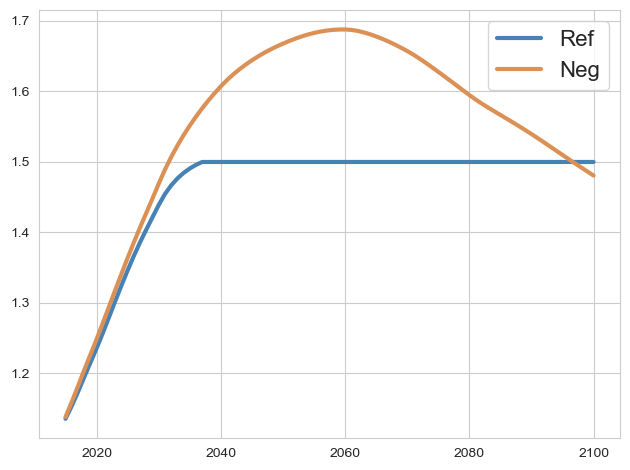

In [84]:
# loading neg and reg pathway 
gmt_ds = pd.read_csv(cset.path_MESMER_char / f'gmt_dataset.csv', index_col = 0)
gmt_ref = np.mean(gmt_ds.loc[:, gmt_ds.columns.str.contains('Ref')].values, axis = 1)
gmt_neg = np.mean(gmt_ds.loc[:, gmt_ds.columns.str.contains('Neg')].values, axis = 1)
with sns.axes_style('whitegrid'):
    plt.figure()
    plt.plot(gmt_ds.index, gmt_ref, color = focus_scenarios_color_dict['Ref'], label = 'Ref', lw = 3) 
    plt.plot(gmt_ds.index, gmt_neg, color = focus_scenarios_color_dict['Neg'], label = 'Neg', lw = 3)
    plt.legend(fontsize = labelsize_medium)
    plt.tight_layout()
    plt.show()

- Compute marginal climate impacts of neg vs. ref

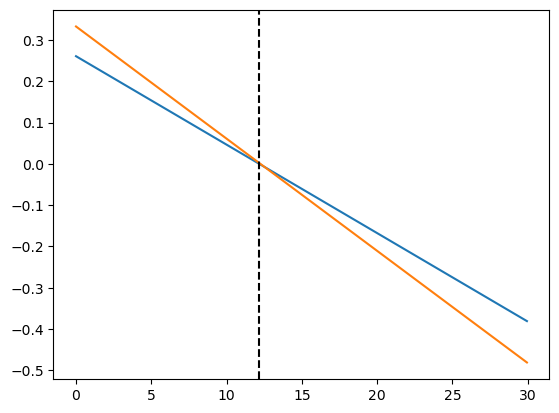

In [85]:
gmt_ref = np.mean(gmt_ds.loc[:, gmt_ds.columns.str.contains('Ref')].values, axis = 1)
gmt_neg = np.mean(gmt_ds.loc[:, gmt_ds.columns.str.contains('Neg')].values, axis = 1)

T_baseline = np.arange(0,30,0.05)
eoc_ref, exc_ref = gmt_ref[-1],  compute_exc(gmt_ref)
eoc_neg, exc_neg = gmt_neg[-1],  compute_exc(gmt_neg)

pred_ref = np.array([[0,0] + [eoc_ref, eoc_ref*t] + [exc_ref, exc_ref*t] + [0]*157 for t in T_baseline])
pred_neg = np.array([[0,0] + [eoc_neg, eoc_neg*t] + [exc_neg, exc_neg*t] + [0]*157 for t in T_baseline])
impact_ref = linreg.predict(pred_ref)
impact_neg = linreg.predict(pred_neg)

plt.figure()
plt.plot(T_baseline, impact_ref)
plt.plot(T_baseline, impact_neg)
plt.axvline(T_baseline[np.argmin(np.abs(impact_ref))], color = 'black', ls = '--')
plt.show()

impact_df = pd.DataFrame(np.array([impact_ref, impact_neg]).T, 
                         index = T_baseline, 
                         columns = ['Ref', 'Neg'])
impact_df.to_csv(cset.path_CHAR_results / f'marginal_impact_ref-neg_{thrshld_str}.csv')

- for all countries with impacts_neg > impacts_ref: find OS trajectories with EOC warming comparable to Ref. 

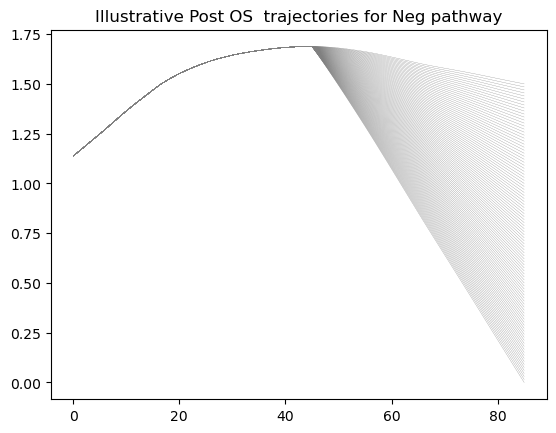

In [86]:
# idea: assume after Neg reches peak warming in 2060, 
# the pathway gradually shifts to other end-of-century temperatures 
# we distribute the shift linearly to post-OS temperatures
# we empirically estimate the impacts of each shifted trajectory and 
# compare impacts to impacts from the Ref pathway
# for each country warmer than 12.2°C. 

# original linear contribution to trajectory
x         = np.linspace(2015, 2100, 86)
p         = np.polyfit([2060, 2100], [gmt_neg[45], gmt_neg[-1]], 1)
y_lin_og  = p[0]*x + p[1]
T_baseline = np.arange(12.2,30,0.05)

x_eocs = np.linspace(0,1.5,100)
EXCs = []

plt.figure()
for x_eoc in x_eocs:
    x         = np.linspace(2015, 2100, 86)
    p         = np.polyfit([2060, 2100], 
                           [gmt_neg[45], x_eoc], 1)
    y_lin     = p[0]*x + p[1]
    
    gmt_neg_adj      = gmt_neg.copy()
    # removing original linear component and adding new 
    # component consistent with x_eoc 
    gmt_neg_adj[45:] += y_lin[45:] - y_lin_og[45:]
    plt.plot(gmt_neg_adj, color = 'grey', alpha = 1, lw = 0.2)
    
    EXCs.append(compute_exc(gmt_neg_adj))
plt.title('Illustrative Post OS  trajectories for Neg pathway')
plt.show()

# computing impacts of each shifted trajectory
IMPACTS_NEG = []
for i, x_eoc in enumerate(x_eocs):
    pred_tmp = np.array([[0,0] + [x_eoc, x_eoc*t] + [EXCs[i], EXCs[i]*t] + [0]*157 for t in T_baseline])
    IMPACTS_NEG.append(linreg.predict(pred_tmp))

In [ ]:
# for each baseline temperature store the Neg trajectory that has 
# the impact most comparable to the Ref trajectory
gmt_trajectories_equal = []
for i,t in enumerate(T_baseline[4:]): 
    idx    = idx_min[i]
    x_eoc  = x_eocs[idx]
    x         = np.linspace(2015, 2100, 86)
    p         = np.polyfit([2060, 2100], [gmt_neg[45], x_eoc], 1)
    y_lin     = p[0]*x + p[1]
    gmt_neg_adj      = gmt_neg.copy()
    gmt_neg_adj[45:] += y_lin[45:]-y_lin_og[45:]
    gmt_trajectories_equal.append(gmt_neg_adj)
gmt_trajectories_equal = np.array(gmt_trajectories_equal)

pd.DataFrame(gmt_trajectories_equal.T, 
             index = np.arange(2015,2101,1), 
             columns = T_baseline[4:]).to_csv(cset.path_CHAR_results / f'Equal_trajectories_by_T-baseline_ref_{thrshld_str}.csv')

In [88]:
warm_isos = regression_df[regression_df.tas_baseline > 12.2].iso.unique()
warm_temperatures = [regression_df[regression_df.iso == iso].loc[:, 'tas_baseline'].mean() for iso in warm_isos]
idx_country = [np.abs(T_baseline[4:]-t).argmin() for t in warm_temperatures]

country_trajectory_df = pd.DataFrame(gmt_trajectories_equal[idx_country, :].T,
                                     index = np.arange(2015,2101,1), 
                                     columns = warm_isos)

country_trajectory_df.to_csv(cset.path_CHAR_results / f'Equal_trajectories_by_country_ref_{thrshld_str}.csv')

- plot results

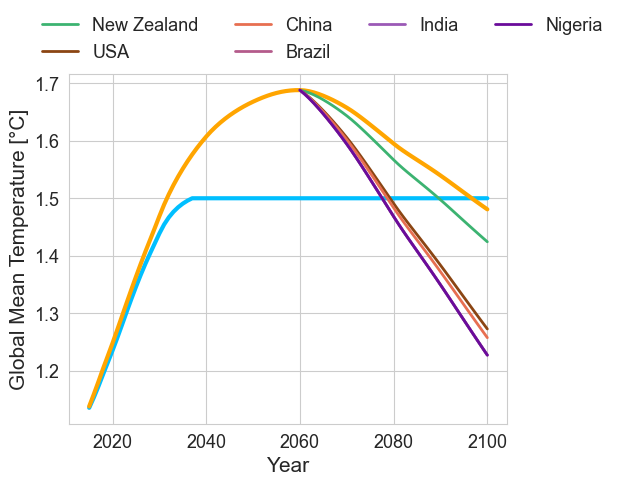

In [89]:
with sns.axes_style('whitegrid'):
    with sns.axes_style('whitegrid'):
        plt.figure(figsize = (6,5))
        plt.plot(np.linspace(2015,2100,86), gmt_ref, color = '#00BFFF', linewidth = 3)
        plt.plot(np.linspace(2015,2100,86), gmt_neg, color = '#FFA500', linewidth = 3)
        # lc  = multiline(np.array([np.linspace(2015,2100,86)[45:] for i in range(501-150)]),  gmt_trajectories_equal[150:, 45:], x_Ts[150:], cmap='RdBu_r', lw=2, alpha =.1)
        # plt.plot(np.linspace(2015,2100,86)[45:],
        #          country_trajectory_df.values[45:, :], color = 'grey', linewidth = 0.5, alpha = 1)
        for i_country, country in enumerate(focus_countries[1:]):
            plt.plot(np.linspace(2015,2100,86)[45:], 
                     country_trajectory_df.loc[:, country].values[45:], 
                     color = focus_countries_colors[i_country+1], 
                     label = focus_countries_names[i_country+1], 
                     linewidth = 2)
        plt.tick_params(labelsize = 13)
        plt.xlabel('Year', fontsize = 15)
        plt.ylabel('Global Mean Temperature [°C]', fontsize = 15)
        plt.legend(ncols = 4, loc  = 'center left', frameon = False, bbox_to_anchor=(-0.1, 1.1), fontsize = 13)
        plt.tight_layout()
        plt.show()